In [ ]:
%load_ext autoreload
%autoreload 3

from functools import partial
from pathlib import Path

import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from PIL import Image
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

import datasets as dsets
import models
import utils
from test import reshape, batched_predict
from mlnoddy.datasets import parse_geophysics, Norm

import rasterio
import tifffile
from datasets.noddyverse import HRLRNoddyverse, NoddyverseWrapper
from datasets.noddyverse import load_naprstek_synthetic as load_naprstek

from inference import (
    load_model,
    load_real_data,
    input_tiler,
    real_inference,
    test_custom_data,
    CustomTestDataset,
    eval,
    plot_canny,
    plt_results,
    save_pred,
)

In [2]:
with open("configs/inference.yaml", "r") as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

scale = 4
filepath = Path(r"D:/luke/data_source/P1134/P1134-grid-tmi.ers")


In [3]:
model, model_name, model_paths = load_model(cfg)
# Define Data ###

spec = cfg["test_dataset"]
dataset = dsets.make(spec["dataset"])
dataset = dsets.make(spec["wrapper"], args={"dataset": dataset})
# dataset.crop = spec["wrapper"]["args"]["crop"]
# ^ this should now be handled in .make()

if cfg["limit_to_plots"]:
    dataset = Subset(dataset, cfg["plot_samples"])

loader = DataLoader(
    dataset,
    batch_size=spec["batch_size"],
    num_workers=cfg.get("num_workers"),
    persistent_workers=bool(cfg.get("num_workers")),
    pin_memory=True,
)

# Pack Options ###
opts = dict(
    model_name=model_name,
    model_path=model_paths[0],
    save_path=Path(cfg["inference_output_dir"] or f"inference/{model_name}"),
    rgb_range=cfg["rgb_range"],
    shave_factor=3,  # pixels to shave (edges may include NaN)
    ids=cfg["plot_samples"],  # Sample IDs
    mag=cfg["test_dataset"]["dataset"]["args"]["load_magnetics"],
    grv=cfg["test_dataset"]["dataset"]["args"]["load_gravity"],
    eval_bsize=cfg["eval_bsize"],
    limit_to_plots=cfg["limit_to_plots"],
    gt_list=cfg["test_dataset"]["dataset"]["args"]["root_path"],
)

scale_min = spec["wrapper"]["args"]["scale_min"]
scale_max = spec["wrapper"]["args"]["scale_max"]

print(
    f"\nModel: {opts['model_path'].absolute()}\n"
    f"Saving to: {opts['save_path'].absolute()}"
)


d:\luke\Miniconda3\envs\lte\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Model: D:\luke\lte_geo\save\_train_swinir-lte_geo\221113-1221_average_aerator_7080\average_aerator_7080_epoch-last.pth
Saving to: d:\luke\lte_geo\inference\average_aerator


In [4]:
# # Do Inference ###
# results_dict = {}
# custom_results_dict = {}

# scale_min = 4
# scale_max = 4

# pbar_m = tqdm(range(scale_min, scale_max + 1))
# for scale in pbar_m:
#     pbar_m.set_description(f"{scale}x scale")
#     opts["shave"] = scale * opts["shave_factor"]

#     # lazy way to reset custom grid opts
#     opts["ids"] = cfg["plot_samples"]
#     opts["gt"] = None
#     opts["set"] = "test"

#     dataset.scale = scale
#     dataset.scale_min = scale
#     dataset.scale_max = scale
#     if cfg["limit_to_plots"]:
#         # Not sure how to better handle Subset dataset
#         dataset.dataset.scale = scale
#         dataset.dataset.scale_min = scale
#         dataset.dataset.scale_max = scale

#     results = eval(model, scale, loader, opts, cfg=cfg)
#     results_dict[f"{scale}x"] = results
#     pbar_m.write(f"{scale}x scale - Mean:")
#     pbar_m.write(
#         ", ".join(
#             f"{metric_name}: {metric_value:.4f}"
#             for metric_name, metric_value in results.items()
#         )
#     )


In [5]:
# plt_results(results_dict, opts)


In [6]:
model.eval()
for i, batch in enumerate(loader):
    inp = batch["inp"].to("cuda", non_blocking=True)
    coord = batch["coord"].to("cuda", non_blocking=True)
    cell = batch["cell"].to("cuda", non_blocking=True)
    # batch["gt"] = batch["gt"].to("cuda", non_blocking=True)

    with torch.no_grad():
        if opts["eval_bsize"]:
            pred = batched_predict(model, inp, coord, cell, opts["eval_bsize"])
        else:
            pred = model(inp, coord, cell)

    pred, batch = reshape(batch, h_pad=0, w_pad=0, coord=coord, pred=pred)
    lr = batch["inp"].detach().cpu().squeeze().numpy()
    hr = batch["gt"].detach().cpu().squeeze().numpy()
    sr = pred.detach().cpu().squeeze().numpy()
    break


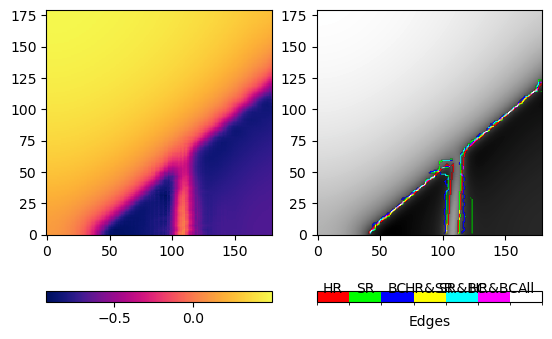

In [24]:
# import cv2
from inference import plot_canny

fig, [ax0, ax1] = plt.subplots(1,2)

c0 = ax0.imshow(sr, cmap=cc.cm.CET_L8, origin="lower", interpolation="nearest")
plt.colorbar(c0, orientation="horizontal", ax=ax0)
plot_canny(
    ax1,
    hr,
    sr,
    np.array(Image.fromarray(lr).resize(hr.shape, Image.Resampling.BICUBIC)),
    sigma=1,
)


In [ ]:
mask = np.zeros_like(hr)
mask[:, ::4] = 1

# cmap.set_bad(alpha=0)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10), dpi=600)
cgry = ax.imshow(hr, cmap=cc.cm.CET_L1, interpolation="nearest", origin="lower")
cclr = ax.imshow(
    hr, cmap=cc.cm.CET_L8, interpolation="nearest", origin="lower", alpha=mask
)
plt.colorbar(mappable=cgry, ax=ax, orientation="horizontal", label="Unsampled")
plt.colorbar(mappable=cclr, ax=ax, orientation="horizontal", label="Line Sampled")
